In [1]:
# Copyright 2018 Anar Amirli
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Try DBSCAN-Clustering Features
In this notebook, we compute desnity-based clustering (DBSCAN) features and see if they can potentially be used to predict segments of interest.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import division

import json
import pickle
import pandas as pd
import numpy as np
import math
from scipy.ndimage.interpolation import shift
import operator
import scipy as sc

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# our common utility functions that are used in different notebooks
from utils import *


pd.options.display.max_columns = None
pd.set_option('compute.use_bottleneck', True)
pd.set_option('compute.use_numexpr', True)

### Finding location where players denisty is more

Need to find a way to assess the degree of clustering (especially clustering around the penalty area). Using DBSCAN k-means might be a way.

Need to find features that can describe clustering of players better than simply calculating average position for all players.

* some players are clustered when there are outliers
* all players are fairly apart from each other

As player tended to keep their vertical structure, we use it to groups together players that are closely packed together in horizontal axis.

with both cases leading to average to high average sum.


Match id:60565
 Half: 1, Min: 7, second: 11
 Half: 1, Min: 7, second: 12
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 0  3  5  6 10 13 15 16 17]
home_X: 93.9688888888889


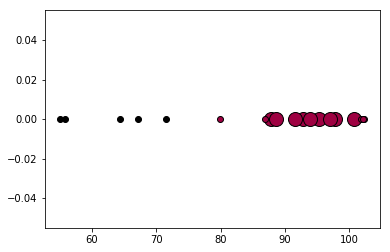

 Half: 1, Min: 7, second: 13
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 0  3  5  6 10 11 13 15 16 17]
home_X: 94.60000000000001


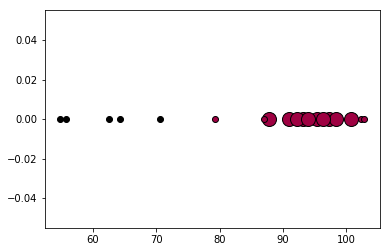

 Half: 1, Min: 7, second: 14
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 0  2  3  5  6  9 10 13 15 16 17]
home_X: 95.04272727272728


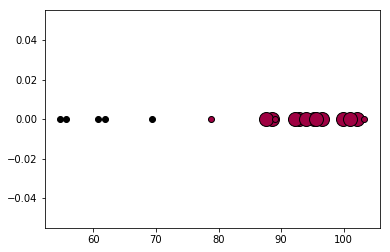

In [18]:
with open('../data/general/matches_2017_2018_v1.json') as matches_json:
    matches = json.load(matches_json)

for match_data in matches:
    id = int(match_data['id'])
    if id==60565:
        print("\nMatch id:" + str(id))

        # defining 3 distinct id in game
        referee_id = 0
        home_team_id = int(match_data['homeId']) 
        away_team_id = int(match_data['awayId']) 

        # all data
        all_data = []
        all_data_count = []

        # home_nonzero
        home_player_count_pitch = []
        home_prev_count = 11

        # home_nonzero
        away_player_count_pitch = []
        away_prev_count = 11

        # player dicts
        home_dict = {} 
        away_dict = {}
        
        home_team_player = []
        away_team_player = []

        # players position ID 
        player_positionId = {'homeTeam' : {}, 'awayTeam' : {}}

        with open('../data/match_' + str(id) + '/roster_data_' + str(id) + '.json', 'r') as file:
            match_squad = json.load(file)

        for roaster in match_squad:
            if roaster['teamId'] == home_team_id:
                home_team_player.append(str(roaster['jerseyNumber']))
                player_positionId['homeTeam'][roaster['jerseyNumber']] = roaster['positionId'] 
            elif roaster['teamId'] == away_team_id:
                away_team_player.append(str(roaster['jerseyNumber']))
                player_positionId['awayTeam'][roaster['jerseyNumber']] = roaster['positionId']
               
        # home players dict data
        home_team_player.sort(key=int)
        home_val = np.arange(0, len(home_team_player))
        home_dict = dict(zip(home_team_player, home_val))
        home_dict_reverse = dict(zip(home_val, home_team_player))


        # away players dict data
        away_team_player.sort(key=int)
        away_val = np.arange(0, len(away_team_player))
        away_dict = dict(zip(away_team_player, away_val))
        away_dict_reverse = dict(zip(away_val, away_team_player))

        # home and away team players' status[0: not playing, 1: playing, 2-left the game], 
        #enter status[0: enter 1st half, 1: enter second half],
        # enter time, and duration, red card
        home_dur_in_out = np.zeros(shape=(len(home_team_player), 5), dtype=np.float)
        away_dur_in_out = np.zeros(shape=(len(away_team_player), 5), dtype=np.float)


        with open('../data/match_' + str(id) + '/players_data_' + str(id) + '.json', 'r') as file:
            player_data = json.load(file)
            
        with open('../data/match_' + str(id) + '/per_sec_data_' + str(id) + '.json', 'r') as file:
            data_persec = json.load(file)


        for player in player_data:
            jersey_number = player['jerseyNumber']
            if player['teamId'] == home_team_id:
                home_dur_in_out[home_dict[str(jersey_number)]][3] = player['duration']
                home_dur_in_out[home_dict[str(jersey_number)]][4] = player['redCard']

            elif player['teamId'] == away_team_id:
                away_dur_in_out[away_dict[str(jersey_number)]][3] = player['duration']
                away_dur_in_out[away_dict[str(jersey_number)]][4] = player['redCard']


        # players's and refree's previous and next x&y data
        home_x_data = np.zeros(shape=(len(home_team_player),2), dtype=np.float)
        home_y_data = np.zeros(shape=(len(home_team_player),2), dtype=np.float)
        
        away_x_data = np.zeros(shape=(len(away_team_player),2), dtype=np.float)
        away_y_data = np.zeros(shape=(len(away_team_player),2), dtype=np.float)

        
        tmp_t = 0
        tmp_t_2 = 0
        # temporary half
        tmp_half = 1

        for d in data_persec:

            match_half_t = int(d['half'])

            # create first average positon data for assigning player at the 2nd half
            if match_half_t != tmp_half and match_half_t==2:
                tmp_half = match_half_t
                shift_times_right = 0

                tmp_t = 45*60

            i = int(d['minute'])*60 + int(d['second'])
            x_pos = round(d['xpos'],2)
            y_pos = round(d['ypos'],2)
            team_id_t = int(d['teamId'])
            speed_t = round(d['speed'],2)
            jersey_number_t = int(d['jerseyNumber'])
            has_ball_teamId_t = int(d['hasballTeamId'])
            has_ball_jerseyId_t = int(d['hasballJerseyNumber'])
        


            # find out how long did 1st half last
            if match_half_t == 1:
                first_half_duration = i
                        
            if (i//60==7 and i%60>10 and i%60<15):
                
                if tmp_t_2!=i:
                       
                    tmp_t_2=i

                    print(" Half: {}, Min: {}, second: {}".format(match_half_t, i//60, i%60))  
                    
                    
                    home_count=0
                    for h_data_i in home_x_data:
                        if h_data_i[1]!=0:
                            home_count+=1
                            
                    away_count=0
                    for a_data_i in away_x_data:
                        if a_data_i[1]!=0:
                            away_count+=1

                    if away_count>0 and home_count>0:
                    
                        hx_data_tmp =[]
                        hy_data_tmp =[]
                        ax_data_tmp =[]
                        ay_data_tmp =[]

                        for p_i in range(len(home_x_data)):
                            if home_x_data[p_i,1]!=0:
                                hx_data_tmp.append(home_x_data[p_i,1])
                                hy_data_tmp.append(home_y_data[p_i,1])



                        for p_i in range(len(away_x_data)):
                            if away_x_data[p_i,1]!=0:
                                ax_data_tmp.append(away_x_data[p_i,1])
                                ay_data_tmp.append(away_y_data[p_i,1])


                        x_all = np.array([np.concatenate((hx_data_tmp,ax_data_tmp), axis=0), np.concatenate((hy_data_tmp, ay_data_tmp), axis=0)])
                        x_all = np.transpose(x_all)

                        x_home = x_all[0:len(hx_data_tmp)]


                        c_n, _ = x_all.shape
                        X_all = np.zeros(shape=(c_n, 2), dtype=np.float)
                        for r_i in range(c_n):
                             X_all[r_i][0] = x_all[r_i][0]


                        c_n, _ = x_home.shape
                        X_home = np.zeros(shape=(c_n, 2), dtype=np.float)
                        for r_i in range(c_n):

                            X_home[r_i][0] = x_home[r_i][0]


                        #### HOME TEAM #####################

                        homeDBSCAN_x=0
                        homeDBSCAN_y=0

                        value_ids = np.zeros(shape=(len(X_all)), dtype=np.int8)

                        for V_i in range(len(X_all)):
                            value_ids[V_i]=V_i

                        val_id=[]


                        db = DBSCAN(eps=10, min_samples=10).fit(X_all)
                        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
                        core_samples_mask[db.core_sample_indices_] = True
                        labels = db.labels_

                        unique_labels = set(labels)

                        max_key = 0
                        if len(Counter(labels))==1 and Counter(labels).most_common(1)[0][0]!=-1:
                            max_key=Counter(labels).most_common(1)[0][0]
                        elif len(Counter(labels))>1:
                            if Counter(labels).most_common(1)[0][0]==-1:
                                max_key = Counter(labels).most_common(2)[1][0]
                            else:
                                max_key = Counter(labels).most_common(2)[0][0]


                        for k_label in unique_labels:
                            class_member_mask = (labels == k_label)
                            if max_key!=-1 and max_key==k_label:
                                val_id = value_ids[class_member_mask & core_samples_mask]


                        if max_key== -1 or len(val_id)==0:
                            homeDBSCAN_x += np.sum(x_all[:,0], axis=0) / len(x_all)
                            homeDBSCAN_y += np.sum(x_all[:,1], axis=0) / len(x_all)
                        else:
                            for value_i in val_id:
                                homeDBSCAN_x += x_all[value_i][0]
                                homeDBSCAN_y += x_all[value_i][0]

                            homeDBSCAN_x/=len(val_id)
                            homeDBSCAN_y/=len(val_id)

                        print(value_ids)
                        print(val_id)

                        print("home_X: {}".format(homeDBSCAN_x))




                        db = DBSCAN(eps=10, min_samples=10).fit(X_all)
                        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
                        core_samples_mask[db.core_sample_indices_] = True
                        labels = db.labels_


                        unique_labels = set(labels)
                        colors = [plt.cm.Spectral(each)
                                  for each in np.linspace(0, 1, len(unique_labels))]
                        for k, col in zip(unique_labels, colors):
                            if k == -1:
                                # Black used for noise.
                                col = [0, 0, 0, 1]

                            class_member_mask = (labels == k)


                            xy = X_all[class_member_mask & core_samples_mask]
                            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                                      markeredgecolor='k', markersize=14)

                            xy = X_all[class_member_mask & ~core_samples_mask]
                            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                                     markeredgecolor='k', markersize=6)


                        plt.show()

        
                # HOME
                if team_id_t == home_team_id: 
                    h_jersey_no = home_dict[str(jersey_number_t)]
                    if player_positionId['homeTeam'][jersey_number_t] != 1 and x_pos!=0 and y_pos!=0:
                        home_x_data[h_jersey_no][1] = x_pos
                        home_y_data[h_jersey_no][1] = y_pos
 
                # AWAY        
                elif team_id_t == away_team_id: 
                    a_jersey_no = away_dict[str(jersey_number_t)]
                    if player_positionId['awayTeam'][jersey_number_t] != 1 and x_pos!=0 and y_pos!=0:
                        away_x_data[a_jersey_no][1] = x_pos
                        away_y_data[a_jersey_no][1] = y_pos
                       
      